In [89]:
from multiprocessing import cpu_count

import jax.numpy as jnp
import jax.lax as lax
import jax

import dynamiqs as dq
import qutip as qt

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

jax.config.update("jax_enable_x64", True)
pd.set_option('display.max_rows', None)
worker_count = max(cpu_count() - 1, 1)

In [2]:
## Spin parameters
h    = 6.6260693e-34       # J.s
mu_N = 5.0507836991e-27    # Nuclear magneton in J/T
g_N  = 0.2355695           # g nuclear 183W (INDC International Nuclear Data Committee)
mu_I = mu_N*g_N            # Nuclear magneton * g nuclear 183W  in J/T
tau = 2*np.pi              # two pi

# Magnetic field
B0 = 0.447 # T
theta = 0*np.pi/180 # rad
phi = 0*np.pi/180 # rad
B_field = np.array([B0*np.sin(theta)*np.cos(phi), B0*np.sin(theta)*np.sin(phi), B0*np.cos(theta)])

# omega_L = 2*np.pi*mu_I/h*1e-6*B0 # rad/us
omega_L = 790.40/1000*2*np.pi

# Hyperfine constants
A = tau * 1e-3 * (-35.2)
B = tau * 1e-3 * 70.4

In [3]:
S = 1/2
nS = int(2*S+1)
Si = qt.qeye(nS)

I = 1/2
nI = int(2*I+1)
Ii = qt.qeye(nI)

Sx, Sy, Sz = qt.jmat(S)
Sp, Sm = qt.spin_Jp(S), qt.spin_Jm(S)

SxI, SyI, SzI = (qt.tensor(op, Ii) for op in (Sx,Sy,Sz))
SpI, SmI = (qt.tensor(op, Ii) for op in (Sp,Sm))

Ix, Iy, Iz = qt.jmat(I)
Ip, Im = qt.spin_Jp(I), qt.spin_Jm(I)

IIx, IIy, IIz = (qt.tensor(Si, op) for op in (Ix,Iy,Iz))
IIp, IIm = (qt.tensor(Si, op) for op in (Ip,Im))

H_NZ = qt.tensor(Si, omega_L*Iz)

H_DD = A*qt.tensor(Sz,Iz) + B*qt.tensor(Sz, Ix)

H0 = H_NZ + H_DD

K00 = H0.eigenstates()[1][0]
K10 = H0.eigenstates()[1][1]
K01 = H0.eigenstates()[1][3]
K11 = H0.eigenstates()[1][2]

In [83]:
jH0 = jnp.array(H0.full())

jK00, jK10, jK01, jK11 = (jnp.array(ket.full()) for ket in (K00, K10, K01, K11))

jSxI, jSyI, jSzI, jSpI, jSmI = (jnp.array(op.full()) for op in (SxI, SyI, SzI, SpI, SmI))

jIIx, jIIy, jIIz, jIIp, jIIm = (jnp.array(op.full()) for op in (IIx, IIy, IIz, IIp, IIm))

In [84]:
pulse_duration = 10000
timesteps = pulse_duration//5

raman_detuning = 1.4*tau

arg1 = {
    't0': 0,
    'pulse_duration': pulse_duration,
    'amplitude': 0.8,
    'phase': 0,
    'detuning': 13.877717976716323
}

arg2 = {
    't0': 0,
    'pulse_duration': pulse_duration,
    'amplitude': 0.5,
    'phase': 0,
    'detuning': raman_detuning
}

def j_square_pulse(t, pulse_duration = 0, amplitude = 0, t0 = 0):
    return jnp.where((t >= t0) & (t < (t0 + pulse_duration)), amplitude/2, 0)

def j_square_pulse_p(t, detuning=0, phase = 0, **args):
  return j_square_pulse(t, **args) * jnp.exp(+1j*(t*detuning+phase))

def j_square_pulse_m(t, detuning=0, phase = 0, **args):
  return j_square_pulse(t, **args) * jnp.exp(-1j*(t*detuning+phase))

def H_args(t, arg1, arg2):
  return jH0+j_square_pulse_p(t, **arg1)*jSpI + j_square_pulse_m(t, **arg1)*jSmI + j_square_pulse_p(t, **arg2)*jSpI + j_square_pulse_m(t, **arg2)*jSmI

Ht = lambda t: H_args(t, arg1, arg2)

psi = jK00
tsave = jnp.linspace(0, pulse_duration, timesteps)
solver=dq.solver.Tsit5(max_steps=1_000_000_000, atol=1e-8)
H = dq.timecallable(Ht)

j_raman_results  = dq.sesolve(H, psi, tsave, exp_ops=[jSpI@jSmI, jIIp@jIIm], solver=solver)

In [85]:
pulse_duration = 10000
timesteps = pulse_duration//5

raman_detuning = 1.4*tau

arg1 = {
    't0': 0,
    'pulse_duration': pulse_duration,
    'amplitude': 0.8,
    'phase': 0,
    'detuning': 13.877717976716323
}

arg2 = {
    't0': 0,
    'pulse_duration': pulse_duration,
    'amplitude': 0.5,
    'phase': 0,
    'detuning': raman_detuning
}

def qt_square_pulse(t, args):
    t0, pulse_duration, amplitude = args['t0'], args['pulse_duration'], args['amplitude']
    return np.where((t >= t0) & (t < (t0 + pulse_duration)), amplitude/2, 0)

def qt_square_pulse_p(t, args): 
    omega = 0

    for arg in args['pulse_args']:
        phase, detuning = arg['phase'], arg['detuning']
        omega += qt_square_pulse(t, arg) * np.exp(+1j*(t*detuning+phase))

    return omega

def qt_square_pulse_m(t, args):
    omega = 0

    for arg in args['pulse_args']:
        phase, detuning = arg['phase'], arg['detuning']
        omega += qt_square_pulse(t, arg) * np.exp(-1j*(t*detuning+phase))

    return omega

H_square_p = [SpI, qt_square_pulse_p]
H_square_m = [SmI, qt_square_pulse_m]

psi = K00
tsave = np.linspace(0, pulse_duration, timesteps)
# options = qt.Options(nsteps=1_000_000_000, atol=1e-8)
options = qt.Options()
H = [H0, H_square_p, H_square_m]

qt_raman_results = qt.sesolve(H, psi, tsave, e_ops=[SpI*SmI, IIp*IIm], args={'pulse_args': [arg1, arg2]}, options=options)

[0.00047379 0.00046768 0.00044807 0.00041328 0.00036586 0.00031521
 0.00027581 0.00026212 0.00028381 0.00034391]
[0.00047379 0.00046768 0.00044807 0.00041328 0.00036586 0.00031521
 0.00027581 0.00026212 0.00028381 0.00034391]


True

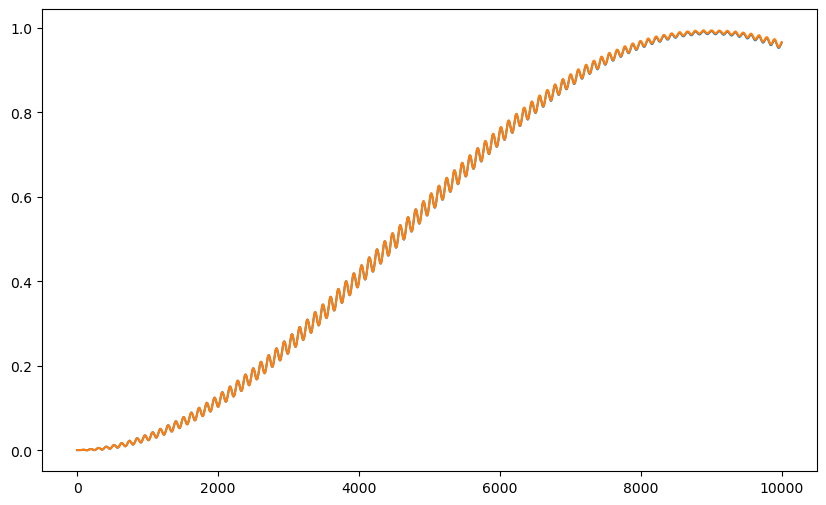

In [88]:
X = tsave
Y1 = qt_raman_results.expect[1]
Y2 = lax.real(j_raman_results.expects[1])

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.plot(X, Y1)
axes.plot(X, Y2)

print(Y1[:10])
print(Y2[:10])
np.allclose(Y1, Y2, atol=1e-3, rtol=1e-3)

In [42]:
def create_op(Nr, Ni, resonator = None, electron = None, nuclear = (None, None)):
    resonator = resonator or qt.qeye(Nr)
    electron = electron or qt.qeye(2)

    nuclear_op, nuclear_index = nuclear
    nuclear = [qt.qeye(2) for _ in range(Ni)]

    if nuclear_op and nuclear_index:
        nuclear[nuclear_index] = nuclear_op

    print(nuclear)

    if Nr < 2:
        return qt.tensor(electron, *nuclear)
    else:
        return qt.tensor(resonator, electron, *nuclear)

In [124]:
wr = 1e-1 * tau # resonator frequency
we = 0 * tau # electron frequency
wi = 1 * tau # nuclear frequency
g = 1 # coupling strength

Nr = 0 # resonator levels
Ni = 1 # number of nucli

a = create_op(Nr, Ni, resonator=qt.destroy(Nr))
em = create_op(Nr, Ni, electron=qt.sigmam())
ix, iy, iz = [create_op(Nr, Ni, nuclear=(qt.sigmax(), i)) for i in range(Ni)], [create_op(Nr, Ni, nuclear=(qt.sigmay(), i)) for i in range(Ni)], [create_op(Nr, Ni, nuclear=(qt.sigmaz(), i)) for i in range(Ni)]
im = [create_op(Nr, Ni, nuclear=(qt.sigmam(), i)) for i in range(Ni)]

In [125]:
A, dA = -0.2, -0.01
B, dB = 0.4, 0.02

# Resonator Hamiltonian
H_R = wr*a.dag()*a

# Electron Zeeman coupling
H_EZ = we*create_op(Nr, Ni, electron=qt.sigmaz())
                    
# Electron-Resonator coupling
H_ER = g*(a.dag() + a)*(em + em.dag())

# Nuclear Zeeman coupling
# H_NZ = qt.tensor(Si, omega_L*Iz)
H_NZ = sum([wi*op for op in iz])

# Fine structure coupling
# H_DD = A*qt.tensor(Sz,Iz) + B*qt.tensor(Sz, Ix)
H_DD = sum([(A-dA*i)*create_op(Nr, Ni, nuclear=(qt.sigmaz(), i), electron=qt.sigmaz()) + (B-dB*i)*create_op(Nr, Ni, nuclear=(qt.sigmax(), i), electron=qt.sigmaz()) for i in range(Ni)])

H0 = H_R + H_EZ + H_ER + H_NZ + H_DD
H0

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[7.11150384 0.         2.         0.        ]
 [0.         7.11150384 0.         2.        ]
 [2.         0.         6.71150384 0.        ]
 [0.         2.         0.         6.71150384]]

In [126]:
ev, es = H0.eigenstates()

In [132]:
df = pd.DataFrame()

for s in es:
    p,e,*i = qt.expect([a.dag()*a, em.dag()*em] + [im[i].dag()*im[i] for i in range(Ni)], s)
    df = pd.concat([df, pd.DataFrame({'# photons': p, 'electron': e, **{'i{}z'.format(ni): i[ni] for ni in range(Ni)}}, index=[0])])

df

,# photons,electron,i0z
0,1.0,0.450248,1.0
0,1.0,0.450248,1.0
0,1.0,0.549752,1.0
0,1.0,0.549752,1.0


In [113]:
s = es[0]
p,e,*i = qt.expect([a.dag()*a, em.dag()*em] + [iz[i].dag()*iz[i] for i in range(Ni)], s)
{'# photons': p, 'electron': e, **{'i{}z'.format(ni): i[ni] for ni in range(Ni)}}

{'# photons': 2.409205340011612,
 'electron': 0.4261849926636204,
 'i0z': 1.0000000000000002,
 'i1z': 1.0000000000000002}

In [133]:
H0

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[7.11150384 0.         2.         0.        ]
 [0.         7.11150384 0.         2.        ]
 [2.         0.         6.71150384 0.        ]
 [0.         2.         0.         6.71150384]]

In [136]:
im[0].dag()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

In [137]:
IIm

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]

In [139]:
qt.tensor(qt.qeye(2), qt.sigmam())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]